<img style="float: right; margin: 0px 0px 15px 15px;" src="https://educationusa.state.gov/sites/default/files/wysiwyg/iteso_logo.jpg" width="520px" height="230px" />

# <span style="color: darkblue; ">Advanced Trading Strategies: _Deep Learning_</span>
`MICROSTRUCTURE AND TRADING SYSTEMS`

Juan Ramón Rocha López 

- Exp: 779950

Mariana Valenzuela Lafarga
    
- Exp: 749770

Repository on GitHub: [Link del repositorio](https://github.com/RaemonRoch/algo-trading)

### Strategy Overview

### Feature Engineering

### Target Variable Definition

### Model Architecture and Design

MLP: For the multilayer perceptron we implement the following structure:
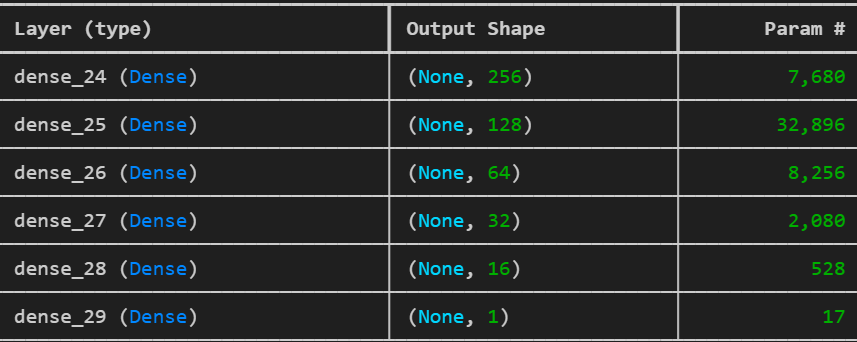

CNN:We implement the following structure for our convolutional network
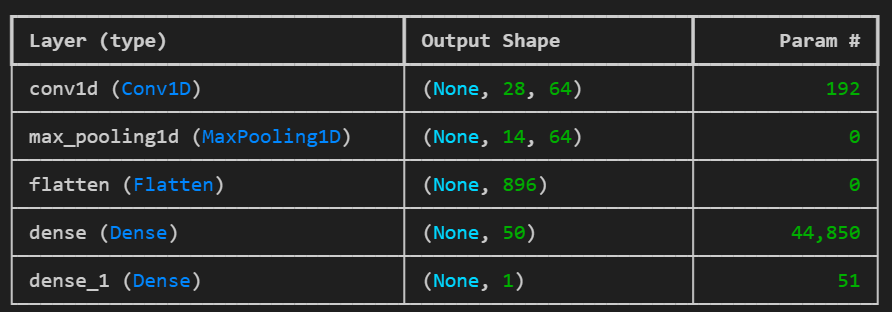

### MLFlow Experiment Tracking

We decided to use the factory pattern to facilitate training and tracking. When training each model, we run an experiment and store the model's metrics and weights.

Example:
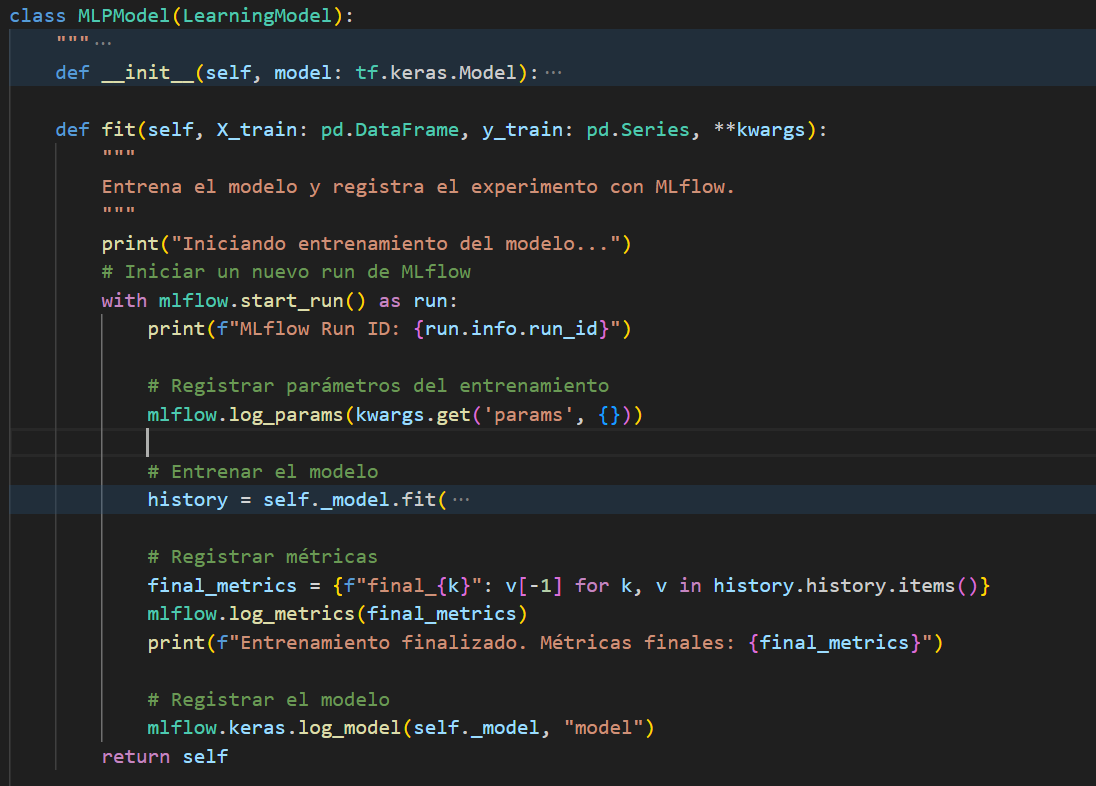


### Data Drift Monitoring

### Backtesting Methodology

The BackTesting module implements a robust system for evaluating the performance of algorithmic trading strategies using K-Fold Cross-Validation, specifically designed for time series.

The goal is to overcome the limitations of a single train/test split, evaluating the consistency and profitability of the strategy across multiple, independent market segments.

* Sequential Partitioning: The core of the system uses sklearn.model_selection.KFold with the parameter shuffle=False. This divides the historical dataset into K sequential and contiguous segments ("folds"), preserving the chronological order essential for financial analysis.

* Sequential Partitioning: The core of the system uses sklearn.model_selection.KFold with the parameter shuffle=False. This divides the historical dataset into K sequential and contiguous segments ("folds"), preserving the chronological order essential for financial analysis.

* Test Isolation (Key Technical Detail): To ensure statistical validity, the simulation state is completely reset before each fold. This is achieved by creating a deep copy (copy.deepcopy) of the initial Exchange object. This step is critical because it ensures that each fold runs as an independent experiment, starting with the same initial capital and with no "memory" of previous trades.

The run_backtest method iterates over each of the K folds, running the strategy only on the data in that segment. The performance of each run (the portfolio's value history) is stored independently.

The end result is a set of K performance simulations. This allows for a comprehensive statistical analysis of the strategy, including its average performance, standard deviation, and consistency across different market conditions, providing a much more reliable evaluation than a single backtest.

### Results and Performance Analysis

### Conclusions